### 数据增强
> * 增加一个已有数据集，使得有更多的多样性
>> * 在语言里面加入各种不同的背景噪声
>> * 改变图片的颜色和形状

### 翻转
> * 左右翻转
> * 上下翻转
### 切割
> * 从图像中切割一块，然后边形到固定形状
>> * 随机高宽比([3/4, 4/3])
>> * 随机大小（[8%,100%]）
>> * 随机位置
### 颜色
> * 改变色调，饱和度，明亮度（[0.5, 1.5])

### 总结
> * 数据增广通过变形数据来获取多样性从而使得模型泛化性能更好
> * 常见图片增广包括翻转，切割，变色

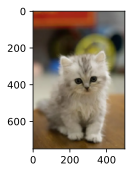

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import limutorch as d2l

d2l.set_figsize()
img = d2l.Image.open('../images/cat1.png')
d2l.plt.imshow(img)

In [5]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

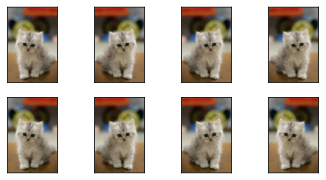

In [6]:
"""左右翻转图像"""
apply(img, torchvision.transforms.RandomHorizontalFlip())

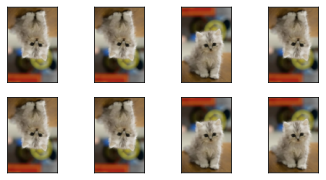

In [7]:
"""上下翻转图像"""
apply(img, torchvision.transforms.RandomVerticalFlip())

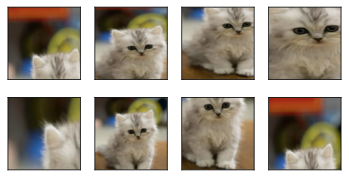

In [8]:
"""随机裁剪"""
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

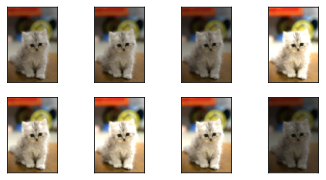

In [9]:
"""随机更改图像的亮度"""
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

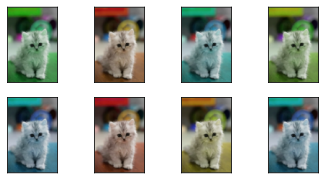

In [10]:
"""随机更改图像的色调"""
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

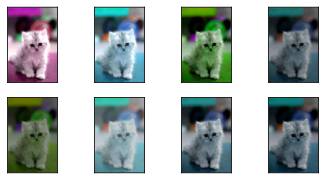

In [12]:
"""随机更改图像的亮度(brightness),对比度(contrast)，饱和度(saturation)和色调(hue)"""
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

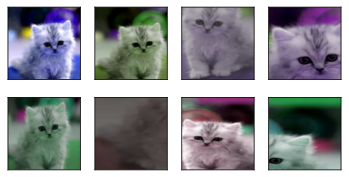

In [13]:
"""结合多种数据增强方法"""
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
     color_aug, shape_aug]
)
apply(img, augs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data\cifar-10-python.tar.gz to ../data


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

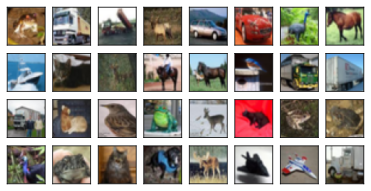

In [ ]:
"""使用数据增广进行训练"""
all_images = torchvision.datasets.CIFAR10(train=True, root='../data', download=True)
d2l.show_images(
    [all_images[i][0] for i in range(32)], 4, 8, scale=0.8
)

In [20]:
"""只使用最简单的随机左右翻转"""
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [15]:
"""定义一个函数，以便于读取图像和应用数据增广"""
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train,
                                             num_workers = d2l.get_dataloader_workers())
    return dataloader

In [16]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X= [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [18]:
"""定义train_with_data_aug函数，使用数据增强来训练模型"""
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_normal_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn. CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.178, train acc 0.939, test acc 0.833
67.2 examples/sec on [device(type='cuda', index=0)]


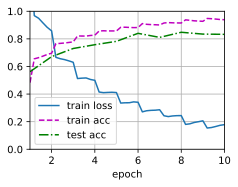

In [21]:
train_with_data_aug(train_augs, test_augs, net)